# Configure Colab notebook to use GPU


Edit > Notebook settings > Hardware accelerator > GPU

# Predict the tag for a Stack Overflow question


In [1]:
import collections
import pathlib
import re
import string
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Download and Stack Overflow dataset and explore the folder content

Download a dataset of programming questions from Stack Overflow. Each question ("How do I sort a dictionary by value?") is labeled with exactly one tag (Python, CSharp, JavaScript, or Java).

In [2]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
dataset = utils.get_file(
    'stack_overflow_16k.tar.gz',
    data_url,
    untar=True,
    cache_dir='',
    cache_subdir='/home/stackoverflow') # Specify download directory
dataset_dir = pathlib.Path(dataset).parent

6053888/6053168 [==============================] - 0s 0us/step


In [3]:
dataset_dir

PosixPath('/home/stackoverflow')

Take a look into the downloaded folder structure on the colab file system. 



In [4]:
# iterate through dataset_dir with .iterdir()
# You will get a generator object, convert generator to list to view content

dirs = list(dataset_dir.iterdir())
dirs

[PosixPath('/home/stackoverflow/train'),
 PosixPath('/home/stackoverflow/README.md'),
 PosixPath('/home/stackoverflow/stack_overflow_16k.tar.gz.tar.gz'),
 PosixPath('/home/stackoverflow/test')]

In [5]:
# PosixPath has operator / that allow you to navigate to the next level
# Ex: posixpath_var/'dir/file.txt'
# Use this operator and .iterdir() to print out the content of the stackoverflow/train folder
train_dir = dirs[0]
#train_dir
list_train = list(train_dir.iterdir())
list_train


[PosixPath('/home/stackoverflow/train/python'),
 PosixPath('/home/stackoverflow/train/javascript'),
 PosixPath('/home/stackoverflow/train/java'),
 PosixPath('/home/stackoverflow/train/csharp')]

The train/csharp, train/java, train/python and train/javascript directories contain many text files, each of which is a Stack Overflow question. Print a file and inspect the data.

### **Show one sentence example from the training dataset. Are you able to tell which tag (python, java, javascript, csharp) this question belongs to?**

In [6]:
# Using navigate to a training file 
# print out its content with open() and read()
sample_file = list_train[1] / '10.txt'
sample_file
with sample_file.open() as f:
  print(f.read())

"incrementing a for loop by decimal value i'm trying to implement a for loop that increments by 0.1. i have one that seems to work just fine for an increment of 0.5. although this may be a 'false positive' since the one for 0.1 gives me some strange values for i?   ..function thisisi() {.    var x = 1;..    for (var i = (x+0.1); i &lt; 2; i += 0.1) {.        console.log('i', i);.    }..};...seems to yield:..i 1.1.i 1.2000000000000002.i 1.3000000000000003.i 1.4000000000000004.i 1.5000000000000004.i 1.6000000000000005.i 1.7000000000000006.i 1.8000000000000007.i 1.9000000000000008...instead of what i need which is 1.1, 1.2, 1.3 etc. ..can someone please point out the root of my idiocy?"



I can tell by the console.log in the sentence that it belongs to the Java



## Preprocess the data so they can be fed into the RNN

### Prepare the dataset for training and validation 

Divide your dataset into three splits: train, validation, and test. The Stack Overflow dataset has already been divided into train and test, but it lacks a validation set. Create a validation set using an 80:20 split of the training data by using the validation_split argument below.

In [7]:
# We are moving onto using the tensorflow preprocessing module
# load the training text dataset with text_dataset_from_directory with validation_split and seed defined

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir, labels='inferred', label_mode='int',
    class_names=None, batch_size=32, max_length=None, shuffle=True, seed=1337,
    validation_split=0.2, subset='training', follow_links=False
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


As you can see above, there are 8,000 examples in the training folder, of which you will use 80% (or 6,400) for training. As you will see in a moment, you can train a model by passing a tf.data.Dataset directly to model.fit. First, iterate over the dataset and print out a few examples, to get a feel for the data.

In [8]:
# generate a batch of text and labels, and then print out text and label
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"user input validation of int length l am writing a class assignment for a simple login program where user will input username, password and mobile number on the console. my problem is on the mobile number, l want them to input a 10 digit number and only 10, if they input less or more than 10 it must show an error. here is my code so far:..console.writeline(""please enter your mobile number:"");.console.writeline(""**please note mobile number should be 10 digits only e.g     07..."");..//avoids exception     handling of entering any type that is not an integer.while (!int.tryparse(console.readline(), out option))    {..console.writeline(""***************************************************"");.                console.writeline(""please enter a valid numerical value!"");.                console.writeline(""please enter option 1 or option 2:"");.}"\n'
Label: 0
Question:  b'"how to make a clone of the object class system.windows.documents.run? i have a class object system.win

The labels are 0, 1, 2 or 3. To see which of these correspond to which string label, you can check the class_names property on the dataset.

In [9]:
# check class_name property of dataset
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Next, you will create a validation and test dataset. You will use the remaining 1,600 reviews from the training set for validation.

In [10]:
# using text_dataset_from_directory and the same validation_split and seed
# generate the validation dataset
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [15]:

test_dir = dirs[3]

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(test_dir)

Found 8000 files belonging to 4 classes.


### Standardize, tokenize, and vectorize the data

The text vectorization layer converts the text to a sequence of token indices. If desired, the user can call this layer's adapt() method on a dataset.
When this layer is adapted, it will analyze the dataset, determine the
frequency of individual string values, and create a 'vocabulary' from them.

In [16]:
# create a TextVectorization layer, check tensorflow for example
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization#example_3

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
 max_tokens=VOCAB_SIZE,
 output_mode='int',
 output_sequence_length=MAX_SEQUENCE_LENGTH)

### **Describe the preprocessing step of the raw sentence data and the label**
**The raw sentence is transformed into a numerical integer representation. The steps are summarized as text standardization, producing substrings, then assigning an integer token.**

Make a text-only dataset (without labels), then call adapt
Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# hint use map function to grab text only from raw_train_ds
# apply adapt to train_text
train_text = raw_train_ds.map(lambda text, labels: text)
int_vectorize_layer.adapt(train_text)

Create a helper function that returns the vectorized question and its label

In [18]:
# define function that takes inpit text and label 
# and outputs vectorize text and the original label
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label


Retrieve a batch (of 32 reviews and labels) from the dataset and Inspect what is the output of text vectorization layer

In [19]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", first_label)

Question tf.Tensor(b'"how to output unicode? hey guys, i need to export data from database which contains unicode(like japanese characters). .while when i trying to export to csv files, it just becomes the garbage.... ..first, i need to read data from database and save it to an datatable .second, i will make a query based on the datatable (using linq).last, export the queried results to csv file ..is there any way to solve this problem? ..thanks a lot."\n', shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int32)


The question is encoded into a 250 length vector (the max length we have specified), and each of its value is a index into our vocabulary set. 

In [20]:
print("'int' vectorized question:",
      int_vectorize_text(first_question, first_label)[0])

'int' vectorized question: tf.Tensor(
[[  24    4  121 2217 1761 1127    3   77    4 1727   81   32  349   66
   297    1    1  386  105   45    3   84    4 1727    4  541  163   10
   104 1920    2 2486  102    3   77    4  170   81   32  349    8  455
    10    4   31  737  200    3   72  109    5  595  395   37    2  737
    47    1 1727    2 9161  389    4  541   39    6   67   75   85    4
   443   13  113  276    5  734    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0

Take a look at the vocabulary created by the text vectorization layer

In [21]:
# you should see a list of words
int_vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'i',
 'to',
 'a',
 'is',
 'in',
 'and',
 'of',
 'it',
 'if',
 'for',
 'this',
 'that',
 'new',
 'blank',
 'have',
 'string',
 'public',
 '0',
 'not',
 'with',
 'my',
 'how',
 'return',
 'but',
 'class',
 'int',
 'code',
 '1',
 'an',
 'from',
 'be',
 'can',
 'am',
 'as',
 'on',
 'function',
 'file',
 'do',
 'void',
 'get',
 'var',
 'want',
 'when',
 'or',
 'using',
 'like',
 'value',
 'so',
 'im',
 'static',
 'else',
 'what',
 '2',
 'at',
 'list',
 'name',
 'are',
 'lt',
 'object',
 'you',
 'gt',
 'method',
 'error',
 'which',
 'there',
 'would',
 'use',
 'number',
 'one',
 'will',
 'all',
 'me',
 'any',
 'line',
 'need',
 'print',
 'by',
 'private',
 'data',
 'array',
 'some',
 'trying',
 'way',
 'then',
 'program',
 'x',
 'true',
 'input',
 '3',
 'only',
 'should',
 'has',
 'here',
 'out',
 'its',
 'false',
 'know',
 'double',
 'user',
 'first',
 'help',
 'just',
 'while',
 'into',
 'why',
 'set',
 'make',
 'time',
 'text',
 'null',
 'problem',
 'was',
 'variab

In [22]:
from collections import Counter

In [23]:

vocab_list = int_vectorize_layer.get_vocabulary()


### **What are the top 10 words in your vocabulary set?**

In [24]:
count = Counter(vocab_list)
top_ten = count.most_common(10) 
top_ten

[('', 1),
 ('[UNK]', 1),
 ('the', 1),
 ('i', 1),
 ('to', 1),
 ('a', 1),
 ('is', 1),
 ('in', 1),
 ('and', 1),
 ('of', 1)]

In [25]:
print("Vocabulary size", len(int_vectorize_layer.get_vocabulary()))

Vocabulary size 10000


Inspect the word <-> index mapping

In [26]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  manually
313 --->  html
Vocabulary size: 10000


Vectorize every question in the dataset by mapping (applying) the *int_vectorize_text* helper funciton to each tuple of question and label. 

In [27]:
# Hint: dataset_name.map(mapping function/layer)
int_train_ds =  raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

### **What is the vector encoding for the first sentence example you’ve checked in question 1?**

In [28]:
int_vectorize_text("incrementing a for loop by decimal value i'm trying to implement a for loop that increments by 0.1. i have one that seems to work just fine for an increment of 0.5. although this may be a 'false positive' since the one for 0.1 gives me some strange values for i?   ..function thisisi() {.    var x = 1;..    for (var i = (x+0.1); i &lt; 2; i += 0.1) {.        console.log('i', i);.    }..};...seems to yield:..i 1.1.i 1.2000000000000002.i 1.3000000000000003.i 1.4000000000000004.i 1.5000000000000004.i 1.6000000000000005.i 1.7000000000000006.i 1.8000000000000007.i 1.9000000000000008...instead of what i need which is 1.1, 1.2, 1.3 etc. ..can someone please point out the root of my idiocy?"
, 1)

(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
 array([[3247,    5,   12,  131,   79,  542,   49,   51,   84,    4,  418,
            5,   12,  131,   14, 5722,   79, 1044,    3,   17,   71,   14,
          311,    4,  138,  104,  301,   12,   31, 1095,    9, 1305, 1451,
           13,  420,   33,    5,   98, 1180,  435,    2,   71,   12, 1044,
          408,   74,   83, 1173,  128,   12,    3,   38,    1,   43,   88,
           30,   12,   43,    3,    1,    3,   60,   55,    3, 1044, 3110,
            3,  311,    4,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    9,   54,    3,   77,   66,    6,  503,  346,  756,
          494,   34,  295,  160,  287,   96,    2,  622,    9,   23,    1,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0, 

## Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

Read more here: https://www.tensorflow.org/guide/data_performance

In [29]:
# check above link
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

## Build the model
Experiment with different models


### **What’s the Keras Embedding layer layer for? What do masking and padding mean in this context?**

The Keras Embedding layer is used for text processing and it takes integer encoded text and converts it into dense vectors of a fixed size. Masking in this context means that when preprocessing, if there is any missing input data then it is skipped. Padding is a form of masking that places masked steps in the preprocess at the beginning or end of a sequence. Padding is needed in order to fit sequences in batches to a standard length.

### Conv1D layer

In [31]:
# Hint: Layers: embed word, convolve embedded vector, find max value in output, 
# lastly give information to dense for class output
# Caution: how many dimension does the embedding output have? So, how many output for conv layer?
def create_conv_model(vocab_size, num_labels, name='conv_model'):
  model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ], name=name)
  return model

### LSTM layer

### **Describe in your own words why LSTM is called long short-term memories?**
"Long" refers to the learned weights and "short-term" refers to the gated-cell state that changes through time. 

In [32]:
# Similar to above but we use LSTM instead of Conv block
def create_lstm_model(vocab_size, num_labels, name="lstm_model"):
    model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 32, mask_zero=True),
      layers.LSTM(32),
      layers.Dense(num_labels)
    ], name=name)
    return model

## Train the model 
Define training operations including loss funtion, optimizers etc.

In [33]:
# create and compile conv model
conv_model = create_conv_model(vocab_size= VOCAB_SIZE + 1, num_labels=4)
conv_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])


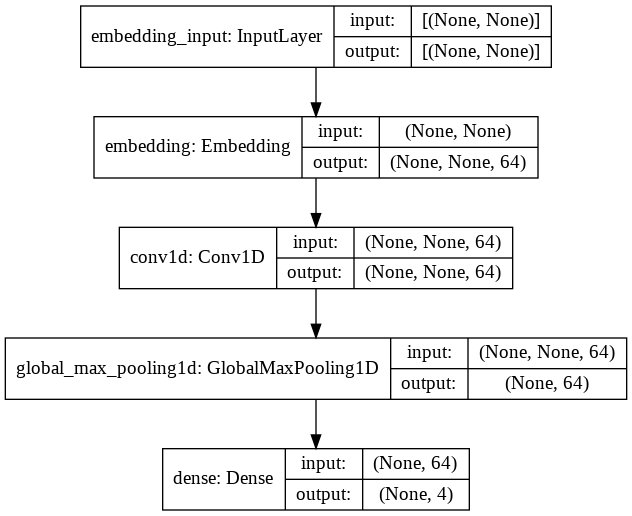

In [34]:
# show model structure
tf.keras.utils.plot_model(conv_model, to_file=dataset_dir/'conv_model.png', show_shapes=True, show_layer_names=True)

In [35]:

conv_model.summary()

Model: "conv_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640064    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 660,868
Trainable params: 660,868
Non-trainable params: 0
_________________________________________________________________


In [36]:
# train model and store training history
history = conv_model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)

Epoch 1/5
200/200 [==============================] - 11s 18ms/step - loss: 1.2970 - accuracy: 0.4038 - val_loss: 0.7107 - val_accuracy: 0.7475
Epoch 2/5
200/200 [==============================] - 2s 9ms/step - loss: 0.6800 - accuracy: 0.7218 - val_loss: 0.4259 - val_accuracy: 0.8675
Epoch 3/5
200/200 [==============================] - 2s 9ms/step - loss: 0.4215 - accuracy: 0.8606 - val_loss: 0.2709 - val_accuracy: 0.9275
Epoch 4/5
200/200 [==============================] - 2s 10ms/step - loss: 0.2497 - accuracy: 0.9340 - val_loss: 0.1839 - val_accuracy: 0.9525
Epoch 5/5
200/200 [==============================] - 2s 10ms/step - loss: 0.1343 - accuracy: 0.9737 - val_loss: 0.1443 - val_accuracy: 0.9594


In [37]:
# create and compile LSTM model
lstm_model = create_lstm_model(vocab_size= VOCAB_SIZE + 1, num_labels=4)
lstm_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
#history = lstm_model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)

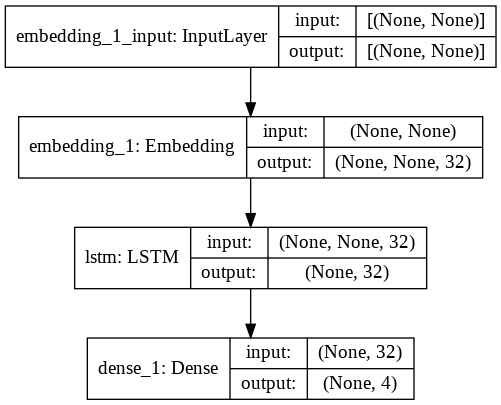

In [38]:
# show model structure
tf.keras.utils.plot_model(lstm_model, to_file=dataset_dir/'lstm_model.png', show_shapes=True, show_layer_names=True)

In [39]:
# print model summary
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320032    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 328,484
Trainable params: 328,484
Non-trainable params: 0
_________________________________________________________________


In [40]:
# train LSTM model and store the history
history = lstm_model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)

Epoch 1/5
200/200 [==============================] - 8s 24ms/step - loss: 1.3376 - accuracy: 0.3124 - val_loss: 0.8916 - val_accuracy: 0.6556
Epoch 2/5
200/200 [==============================] - 4s 19ms/step - loss: 0.8409 - accuracy: 0.6472 - val_loss: 0.7613 - val_accuracy: 0.6406
Epoch 3/5
200/200 [==============================] - 4s 20ms/step - loss: 0.6534 - accuracy: 0.7006 - val_loss: 0.6948 - val_accuracy: 0.7225
Epoch 4/5
200/200 [==============================] - 4s 20ms/step - loss: 0.5889 - accuracy: 0.7284 - val_loss: 0.5404 - val_accuracy: 0.7606
Epoch 5/5
200/200 [==============================] - 4s 18ms/step - loss: 0.4665 - accuracy: 0.7980 - val_loss: 0.4524 - val_accuracy: 0.8150


## Evaluate the model

In [41]:
# evaluate both model using the .evaulate(valid_dataset_name) method 
conv_loss, conv_accuracy = conv_model.evaluate(int_test_ds)
lstm_loss, lstm_accuracy = lstm_model.evaluate(int_test_ds)

print("Conv model accuracy: {:2.2%}".format(conv_accuracy))
print("Lstm model accuracy: {:2.2%}".format(lstm_accuracy))

250/250 [==============================] - 2s 7ms/step - loss: 0.8352 - accuracy: 0.6678
Conv model accuracy: 80.77%
Lstm model accuracy: 66.78%


### **What the difference between using Conv1D vs LSTM?**
The difference between Conv1D and LSTM is that Conv1D is a CNN with feed-forward neural network that takes in fixed inputs and LSTM is a RNN that takes arbitrary inputs and uses internal memory through an arbitrary number sequences as opposed to feed-forward. 

### **Inspect one single Keras LSTM layer by feeding a random vector to it.**


**What shape of the input does it require? What is the output shape?**

In [42]:
inputs = tf.random.normal([32, 10, 8])
lstm = tf.keras.layers.LSTM(4, return_sequences=False, return_state=False)
output = lstm(inputs)
print(output)


tf.Tensor(
[[ 0.5416998  -0.26920247  0.3694367   0.19307688]
 [ 0.0489025   0.41744328 -0.19781019  0.08844201]
 [ 0.02990071 -0.09354813  0.02644516 -0.14821613]
 [ 0.10801884 -0.17022859  0.09193012  0.13112025]
 [ 0.01283436 -0.23212208 -0.05651913  0.08452439]
 [-0.03342361  0.2700491  -0.0757193  -0.14002499]
 [-0.37562978 -0.08785688 -0.18351646  0.29969433]
 [-0.15179402 -0.03882455  0.6120008   0.12287674]
 [-0.00061742 -0.32188407 -0.08928755 -0.10108238]
 [-0.01061878  0.03166382  0.05129217 -0.38962704]
 [ 0.22564965 -0.2473115   0.09049725 -0.0473148 ]
 [-0.06300218  0.12197639  0.36868438  0.01658324]
 [-0.13427667 -0.02802395  0.34528428 -0.11948168]
 [-0.04779446  0.19854699  0.07797377 -0.3942359 ]
 [-0.08691905  0.20147607 -0.07883731  0.16308522]
 [ 0.16325419  0.14452401  0.19431673 -0.01979698]
 [ 0.03411062 -0.05240791 -0.03304502  0.04876269]
 [-0.05661613 -0.09669873  0.02179534 -0.00405689]
 [ 0.4095663  -0.05191997  0.06352722 -0.06333224]
 [ 0.01233283  0.028

### **Set return_sequences and return_states to be True. What is the output shape now?**

In [43]:
inputs = tf.random.normal([32, 10, 8])
lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)
output = lstm(inputs)
print(output)

[<tf.Tensor: shape=(32, 10, 4), dtype=float32, numpy=
array([[[ 9.73760933e-02,  8.12385157e-02,  3.97059917e-02,
          8.46056151e-04],
        [ 3.56545687e-01, -1.55766942e-02, -2.28825018e-01,
         -4.07166421e-01],
        [ 2.78798252e-01, -3.06185901e-01,  3.60626541e-02,
         -1.58063740e-01],
        ...,
        [-6.23288900e-02,  1.09266020e-01,  2.57845730e-01,
          9.58026871e-02],
        [-2.02001959e-01,  2.76988357e-01,  1.85978845e-01,
          2.66260117e-01],
        [-1.43365324e-01,  5.12081459e-02,  3.38123828e-01,
          1.49820909e-01]],

       [[ 2.16994286e-01, -7.69531205e-02,  8.33684132e-02,
         -5.58707304e-02],
        [ 2.34970719e-01,  2.04708531e-01,  1.49963707e-01,
          1.15217589e-01],
        [ 1.45814300e-01,  9.68681946e-02,  1.87470406e-01,
          4.94340882e-02],
        ...,
        [ 1.91831276e-01, -2.67677195e-02,  6.78203106e-02,
         -2.76441760e-02],
        [ 9.92510021e-02,  9.78374407e-02,  1.02

### **Explain the difference between return_sequences and return_states.**

Return sequences provides the output from the hidden states and return states provides access to the hidden sequence output and state. 

## Export the model
In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained

In [44]:
# combine vectorization layer with LSTM model using Sequential 
export_model = tf.keras.Sequential(
    [int_vectorize_layer, lstm_model],)

# compile combined model
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [45]:
export_model.evaluate(raw_test_ds)

250/250 [==============================] - 7s 17ms/step - loss: 2.6623 - accuracy: 0.6776


[2.566737413406372, 0.6677500009536743]

## Run inference on new data

Now your model can take raw strings as input and predict a score for each label using model.predict. Define a function to find the label with the maximum score:

In [46]:
# convert one-hot vector output to int, then int to class name string
def get_string_labels(predicted_scores_batch):
  predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
  predicted_labels = tf.gather(raw_train_ds.class_names, predicted_int_labels)
  return predicted_labels

In [47]:
# predict and verify the inputs using your combined model
inputs = [
    "how do I extract keys from a dict into a list?",  # python
    "debug public static void main(string[] args) {...}",  # java
]
predicted_scores = export_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
for input, label in zip(inputs, predicted_labels):
    print("Question: ", input)
    print("Predicted label: ", label.numpy())

Question:  how do I extract keys from a dict into a list?
Predicted label:  b'python'
Question:  debug public static void main(string[] args) {...}
Predicted label:  b'java'


## Plot training accuracy and loss 

In [48]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])

In [49]:
history_conv = conv_model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)
history_lstm = lstm_model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)

Epoch 1/5
200/200 [==============================] - 2s 9ms/step - loss: 0.0544 - accuracy: 0.9933 - val_loss: 0.1285 - val_accuracy: 0.9613
Epoch 2/5
200/200 [==============================] - 2s 9ms/step - loss: 0.0262 - accuracy: 0.9981 - val_loss: 0.1230 - val_accuracy: 0.9625
Epoch 3/5
200/200 [==============================] - 2s 9ms/step - loss: 0.0139 - accuracy: 0.9997 - val_loss: 0.1240 - val_accuracy: 0.9638
Epoch 4/5
200/200 [==============================] - 2s 9ms/step - loss: 0.0084 - accuracy: 0.9998 - val_loss: 0.1266 - val_accuracy: 0.9638
Epoch 5/5
200/200 [==============================] - 2s 10ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.1297 - val_accuracy: 0.9638
Epoch 1/5
200/200 [==============================] - 4s 19ms/step - loss: 0.3617 - accuracy: 0.8548 - val_loss: 0.3745 - val_accuracy: 0.8769
Epoch 2/5
200/200 [==============================] - 4s 19ms/step - loss: 0.2712 - accuracy: 0.9062 - val_loss: 0.2877 - val_accuracy: 0.9044
Epoch 3/5


### Conv Accuracy Vs. Epoch

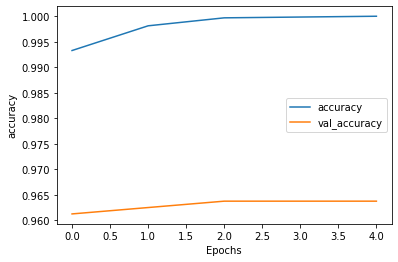

In [50]:
plot_graphs(history_conv, 'accuracy')

### Conv Loss Vs. Epoch

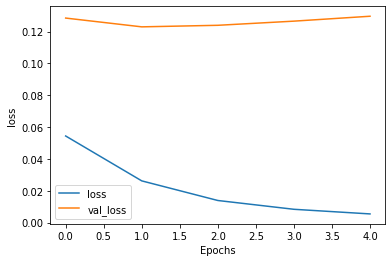

In [51]:
plot_graphs(history_conv, 'loss')

### LSTM Accuracy Vs. Epoch

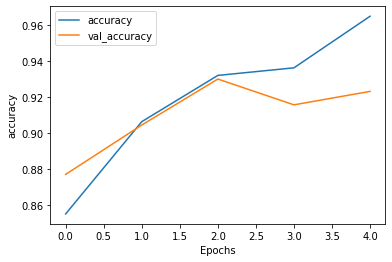

In [52]:
plot_graphs(history_lstm, 'accuracy')

### LSTM Loss Vs. Epoch

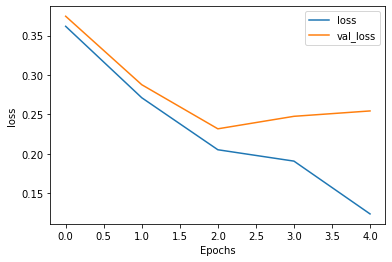

In [53]:
plot_graphs(history_lstm, 'loss')

## **What do you observe?**

From the LSTM plots, I can observe that the accuracy vs epoch plot has a greater accuracy with validation data and for the loss plot the validation data has a lower loss, prior to the second epoch. However, the plots for training and test data flip where the actual accuracy is higher than the validation accuracy (val_accuracy). 

## Visualize the word vector embedding

Two ways to get word embedding. Think about why they are equivalent. 

In [54]:
# get embedding layer and analyze its weights
embedding_layer = conv_model.get_layer('embedding')

word_embed = embedding_layer(np.arange(VOCAB_SIZE+1))
word_embed.shape

TensorShape([10001, 64])

In [55]:
word_embed[0, :]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 0.08968252, -0.0583824 ,  0.00957473, -0.03589929,  0.00896554,
        0.01699897, -0.02269583, -0.07738094, -0.00210379,  0.00225318,
       -0.00237182,  0.07951192,  0.05836385,  0.05285733,  0.02255994,
        0.02955227,  0.00955385,  0.06700115, -0.05147382, -0.11808015,
       -0.00173154,  0.0513249 , -0.00835571, -0.04665393, -0.00347297,
       -0.01208604, -0.04105161,  0.09015147,  0.02528976,  0.0398793 ,
       -0.00766432, -0.0142188 , -0.03001187, -0.01180125,  0.01507591,
       -0.0578781 ,  0.01617985, -0.0405949 ,  0.01548876, -0.00849127,
       -0.04358443,  0.0746019 , -0.00889953,  0.0379394 ,  0.05164954,
       -0.02918999,  0.06019968, -0.02872108,  0.05231274, -0.00811969,
       -0.00600024,  0.05580264,  0.02984324,  0.06188159, -0.01902494,
       -0.05995657,  0.09008674, -0.07127587,  0.05993875, -0.04202913,
       -0.00321401,  0.00040942, -0.07132041,  0.04478005], dtype=float32)>

In [56]:
vocab = word_embed
print(len(vocab))
print(vocab)

10001
tf.Tensor(
[[ 8.96825194e-02 -5.83823994e-02  9.57473181e-03 ...  4.09423228e-04
  -7.13204071e-02  4.47800457e-02]
 [-4.01798412e-02  8.75240657e-04 -6.78419545e-02 ...  5.01137711e-02
  -5.22349179e-02  2.69080885e-02]
 [ 4.92461212e-02  1.74341798e-02  4.36902009e-02 ...  5.99866360e-03
  -1.68660983e-01 -4.55118939e-02]
 ...
 [-5.80616184e-02 -2.32418142e-02 -3.10345627e-02 ... -2.64148675e-02
   4.39880714e-02 -6.33907169e-02]
 [ 4.75949946e-06  1.13114631e-02 -1.19635435e-02 ...  6.04076358e-03
  -3.10366452e-02  3.83100696e-02]
 [ 2.54654624e-02 -4.71618176e-02 -8.93294811e-03 ... -4.02271524e-02
  -3.45310345e-02  4.35909890e-02]], shape=(10001, 64), dtype=float32)


In [57]:
# project weights to 2 dimensional or 3 dimensional for visualization
from sklearn.manifold import TSNE

word_proj = TSNE(n_components=3).fit_transform(word_embed)

print(word_proj.shape)

(10001, 3)


In [58]:
# visualize projected weight with plotly
import plotly.express as px

fig = px.scatter(word_proj, x=0, y=1)

fig.show()

### Visualize with Embedding Projector

In [59]:
vocabulary = int_vectorize_layer.get_vocabulary()

Write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org/), you will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [60]:
weights = conv_model.get_layer('embedding').get_weights()[0]

In [61]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocabulary):
  if  index == 0: continue # skip 0, it's padding.
  vec = word_embed[index] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

KeyboardInterrupt: ignored

In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception as e:
  pass

### NOTE: the above code was not run again because I had already downloaded the files already and tried to project them as shown below. 

## Took too long to compute each time I tried to visualize it.

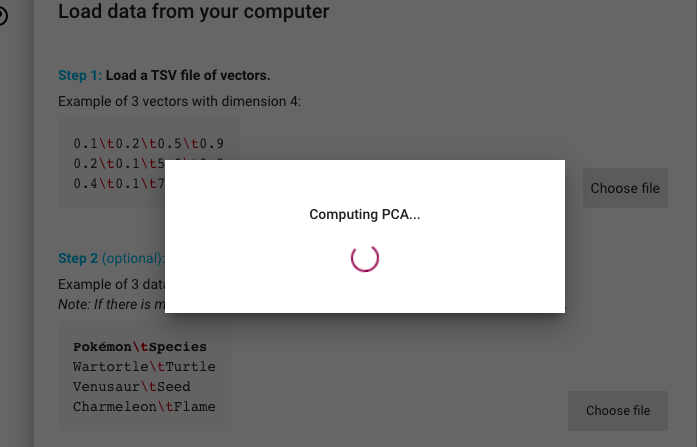

## **Export the model to take raw strings as inputs (Hint: compile the TextVectorization layer and the model together to a new model). Take the following questions as input, what are the predicted tags?**

In [62]:
# combine vectorization layer with LSTM model using Sequential 
exported_model = tf.keras.Sequential(
    [int_vectorize_layer, conv_model],)

# compile combined model
exported_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [65]:
inputs = [
    "how do I extract keys from a dict into a list?",
    "debug public static void main(string[] args) ...",
]
predicted_scores = exported_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
for input, label in zip(inputs, predicted_labels):
    print("Question: ", input)
    print("Predicted label: ", label.numpy())


Question:  how do I extract keys from a dict into a list?
Predicted label:  b'python'
Question:  debug public static void main(string[] args) ...
Predicted label:  b'java'


These results come out to be true because a dict is found in python and public static void main(string... is java language.

The conceptual difference between text classification and image classification is that image classification uses more spatial information that is analyzed in the cnn through layers going around different spaces of the image and filtering out pixels. Text classification involves more temporal information that is analyzed with relation and time and focuses more on sequences to than feedforwarding to save information at each layer. 